In [1]:
import hoomd
import pickle
import gsd.hoomd
import numpy as np

import warnings
warnings.filterwarnings('ignore')


### Create pps atomistic simulation to collect positions of constituent particles and COM 

In [2]:
from flowermd.library import PPS, OPLS_AA_PPS
from flowermd.base import Pack,  Simulation

/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')
/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/numexpr/expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


In [3]:
pps = PPS(num_mols=2, lengths=1)
system = Pack(molecules=pps, density=0.2)

In [4]:
system.apply_forcefield(r_cut=2.5, force_field=OPLS_AA_PPS(), auto_scale=True, remove_charges=True, scale_charges=True, remove_hydrogens=True)

/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/gmso/core/topology.py:818: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_scales[index][scaling_interaction_idxes[interaction]] = value
/home/marjanalbooyeh/miniconda3/envs/ml-pps/lib/python3.9/site-packages/gmso/core/topology.py:818: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_scales[index][scaling_interaction_idxes[interaction]] = value


No charged group detected, skipping electrostatics.


In [5]:
pps_aa_simulation = Simulation.from_system(system)

Initializing simulation state from a gsd.hoomd.Frame.


In [6]:
frame = pps_aa_simulation.state.get_snapshot()

In [7]:
positions = frame.particles.position
# indices of constituent particles
constituent_indx = [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12, 13]]

In [8]:

com_mass = []
com_positions = []

for indx in constituent_indx:
    total_mass = np.sum(frame.particles.mass[indx])
    com_mass.append(total_mass)
    com_positions.append(
                np.sum(
                    frame.particles.position[indx]
                    * frame.particles.mass[indx, np.newaxis],
                    axis=0,
                )
                / total_mass
            )

In [9]:
rel_const_pos =  positions[constituent_indx[0]] - com_positions[0]
rel_const_pos

array([[ 0.08849504,  0.07669724,  0.64043651],
       [-0.02556489, -0.26707529,  0.49990807],
       [-0.07843468, -0.31309532,  0.11771188],
       [-0.01726601, -0.01489721, -0.12452878],
       [-0.08479617, -0.07348143, -0.61360397],
       [ 0.09703805,  0.32916023,  0.01655017],
       [ 0.14977624,  0.3746983 ,  0.39882241]])

### Create rigid body simulation

In [36]:

rigid_simulation = hoomd.Simulation(device=hoomd.device.GPU(), seed=1)
rigid_simulation.create_state_from_gsd(filename='pps_rigid_initial_run.gsd')

In [37]:
const_particle_types = list(np.asarray(frame.particles.types)[list(frame.particles.typeid)][constituent_indx[0]])

In [38]:
rigid = hoomd.md.constrain.Rigid()
rigid.body['rigid'] = {
    "constituent_types":const_particle_types,
    "positions": rel_const_pos,
    "orientations": [(1.0, 0.0, 0.0, 0.0)]* len(rel_const_pos),
}

In [39]:
integrator = hoomd.md.Integrator(dt=0.005, integrate_rotational_dof=True)
rigid_simulation.operations.integrator = integrator
integrator.rigid = rigid
kT = 1.5
rigid_centers_and_free = hoomd.filter.Rigid(("center", "free"))
nvt = hoomd.md.methods.ConstantVolume(
    filter=rigid_centers_and_free,
    thermostat=hoomd.md.methods.thermostats.Bussi(kT=kT))
integrator.methods.append(nvt)

#### define forces

In [40]:
cell = hoomd.md.nlist.Cell(buffer=0, exclusions=['body'])

lj = hoomd.md.pair.LJ(nlist=cell)

# use aa pps simulation to define lj and special lj forces between constituent particles
for k, v in dict(pps_aa_simulation.forces[0].params).items():
    lj.params[k] = v
    lj.r_cut[k] = 2.5

lj.params[('rigid', ['rigid', 'ca', 'sh'])]= dict(epsilon=0, sigma=0)
lj.r_cut[('rigid', ['rigid', 'ca', 'sh'])] = 0

In [41]:
integrator.forces.append(lj)

In [42]:
rigid_simulation.state.thermalize_particle_momenta(filter=rigid_centers_and_free,
                                             kT=kT)

rigid_simulation.run(0)

#### Add loggers

In [43]:
log_quantities = [
                    "kinetic_temperature",
                    "potential_energy",
                    "kinetic_energy",
                    "volume",
                    "pressure",
                    "pressure_tensor",
                ]
logger = hoomd.logging.Logger(categories=["scalar", "string", "particle"])
logger.add(rigid_simulation, quantities=["timestep", "tps"])
thermo_props = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
rigid_simulation.operations.computes.append(thermo_props)
logger.add(thermo_props, quantities=log_quantities)

for f in integrator.forces:

    logger.add(f, quantities=["energy", "forces", "energies"])

gsd_writer = hoomd.write.GSD(
    filename="rigid_pps_trajectory.gsd",
    trigger=hoomd.trigger.Periodic(int(1)),
    mode="wb",
    logger=logger,
    filter=hoomd.filter.All(),
    dynamic=["momentum", "property"]
    )

rigid_simulation.operations.writers.append(gsd_writer)

In [44]:
rigid_simulation.operations.writers[0].flush()

## sample simulation data with MC

In [45]:
rigid_simulation.state.get_snapshot().particles.position

array([[-3.27664495, -1.2271961 , -3.80518508],
       [ 1.44320226, -1.3552891 , -2.81317234],
       [-2.88262228, -1.69517681, -3.58244544],
       [-3.2636991 , -1.71056834, -3.50841155],
       [-3.49906415, -1.43138594, -3.6412553 ],
       [-3.35325516, -1.13616431, -3.84844648],
       [-3.65415839, -0.7788171 , -4.01858518],
       [-2.9716266 , -1.12114572, -3.92246198],
       [-2.73665727, -1.40056108, -3.7894072 ],
       [ 1.10566543, -1.1082078 , -3.31206364],
       [ 0.95540237, -1.39690057, -3.09989631],
       [ 1.15666101, -1.54451911, -2.80208644],
       [ 1.50886264, -1.4033753 , -2.71619867],
       [ 1.76660149, -1.59202481, -2.33518812],
       [ 1.65895694, -1.11422332, -2.92881819],
       [ 1.45732126, -0.96692759, -3.22653304]])

In [46]:
sample_positions = []
sample_orientations = []
sample_energies = []
sample_forces = []
sample_torques = []

for i in range(30000):
    rigid_simulation.run(1)
    sample_energies.append(rigid_simulation.operations.integrator.forces[0].energy)
    with rigid_simulation.state.cpu_local_snapshot as data:
        com_idx = data.particles.rtag[[0, 1]]
        sample_positions.append(data.particles.position[com_idx])
        sample_orientations.append(data.particles.orientation[com_idx])
        sample_forces.append(data.particles.net_force[com_idx])
        sample_torques.append(data.particles.net_torque[com_idx])
rigid_simulation.operations.writers[0].flush()


In [47]:
min(sample_energies)

-4.672845407470986

In [48]:
max(sample_energies)

3.744924511660596

In [49]:
L = rigid_simulation.state.get_snapshot().configuration.box[0]
L

16.98674774169922

In [50]:
def adjust_periodic_boundary(pos, box_len):
    adjusted_pos = []
    for x in pos:
        if x > (box_len/2):
            adjusted_pos.append(x - box_len/2)
        if x < (-box_len/2):
            adjusted_pos.append(x + box_len/2)
        else:
            adjusted_pos.append(x)
    return np.asarray(adjusted_pos)
        

In [62]:
positions_array = np.asarray(sample_positions)
adjusted_positions = []
dr_array = []
for (pos_1, pos_2) in positions_array:
    pos_1_adj = adjust_periodic_boundary(pos_1, L)
    pos_2_adj = adjust_periodic_boundary(pos_2, L)
    adjusted_positions.append([pos_1_adj, pos_2_adj])
    dr_array.append(np.linalg.norm(pos_1_adj - pos_2_adj))

In [63]:
dr = np.asarray(dr_array)
keep_idx = np.where(dr<3)[0]
keep_idx

array([  323,   324,   325, ..., 22954, 22955, 22956])

In [66]:
np.asarray(adjusted_positions).shape

(30000, 2, 3)

In [67]:

keep_dr = dr[keep_idx]
keep_adjusted_positions = np.asarray(adjusted_positions)[keep_idx]
keep_energy = np.asarray(sample_energies)[keep_idx]
keep_force = np.asarray(sample_forces)[keep_idx]
keep_position = np.asarray(sample_positions)[keep_idx]
keep_torque = np.asarray(sample_torques)[keep_idx]
keep_orientation = np.asarray(sample_orientations)[keep_idx]

In [68]:
import matplotlib.pyplot as plt


(-5.0, 4.0)

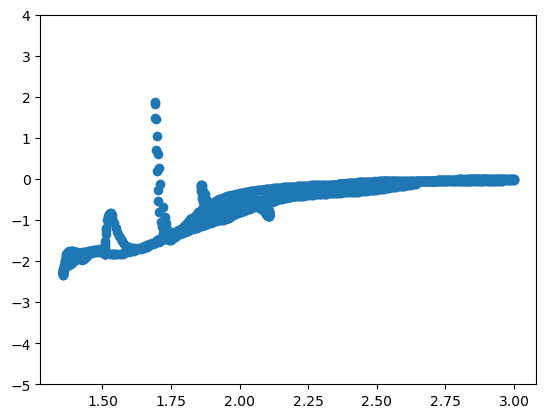

In [73]:
plt.scatter(dr[keep_idx], keep_energy/2)
plt.ylim(-5, 4)

In [76]:
keep_dr[1255]

1.355385665838204

## assemble data

In [78]:
import rowan

In [79]:
particle_pos = []
neighbor_pos = []
features = []
particle_force = []
particle_torque = []
particle_energy = []
for pos, orient, force, torque, energy in zip(keep_adjusted_positions, keep_orientation, keep_force,keep_torque, keep_energy):
    particle_pos.extend([pos[0], pos[1]])
    neighbor_pos.extend([pos[1], pos[0]])
    dr_1 = pos[0] - pos[1]
    dr_2 = pos[1] - pos[0]

    # r = np.linalg.norm(dr_1, keepdims=True)
    
    q1 = orient[0]
    q2 = orient[1]
    
    dr_1_q = np.concatenate([[0], dr_1])
    dr_2_q = np.concatenate([[0], dr_2])

    # calculate q1 applied to q2 and vice versa
    q1q2 = rowan.multiply(q1, rowan.conjugate(q2))
    q2q1 = rowan.multiply(q2, rowan.conjugate(q1))

    # rotate q1 and q2 based on vector dr_1
    q1_dr1_rotated = rowan.multiply(dr_1_q, rowan.multiply(q1, rowan.conjugate(dr_1_q)))
    q2_dr1_rotated = rowan.multiply(dr_1_q, rowan.multiply(q2, rowan.conjugate(dr_1_q)))

    # rotated q2 and q1 based on vector dr_2
    q2_dr2_rotated = rowan.multiply(dr_2_q, rowan.multiply(q2, rowan.conjugate(dr_2_q)))
    q1_dr2_rotated = rowan.multiply(dr_2_q, rowan.multiply(q1, rowan.conjugate(dr_2_q)))
                                    

    features_1 = np.concatenate([dr_1, q1, q2, q1q2, q2q1, q1_dr1_rotated, q2_dr1_rotated])
    features_2 = np.concatenate([dr_2, q2, q1, q2q1, q1q2, q2_dr2_rotated, q1_dr2_rotated])

    features.extend([features_1, features_2])
    particle_force.extend([force[0], force[1]])
    particle_torque.extend([torque[0], torque[1]])
    particle_energy.extend([energy/2, energy/2])

In [80]:
len(particle_force)

3002

In [82]:
import pandas as pd
columns = [
    "particle_pos",
    "neighbor_pos",
    "features",
    "force",
    "torque",
    "energy"
]

new_traj_df = pd.DataFrame(columns=columns)
new_traj_df["particle_pos"] = particle_pos
new_traj_df["neighbor_pos"] = neighbor_pos
new_traj_df["features"] = features
new_traj_df["force"] = particle_force
new_traj_df["torque"] = particle_torque
new_traj_df["energy"] = particle_energy

In [83]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)

In [84]:
target_datapath="/home/erjank_project/marjan/pps_force_learner/datasets/random"

In [86]:
import os
new_traj_df.to_pickle(os.path.join(target_datapath, "raw.pkl"))

In [87]:
new_traj_df = new_traj_df.sample(frac=1).reset_index(drop=True)

test_frac = 0.1
val_frac = 0.1

dataset_len = new_traj_df.shape[0]
test_len = int(dataset_len * test_frac)
val_len = int(dataset_len * val_frac)

test_df = new_traj_df.iloc[:test_len]

val_df = new_traj_df.iloc[test_len: test_len + val_len]

train_df = new_traj_df.iloc[test_len + val_len:]

In [90]:
train_df.to_pickle(os.path.join(target_datapath, 'train.pkl'))
val_df.to_pickle(os.path.join(target_datapath, 'val.pkl'))
test_df.to_pickle(os.path.join(target_datapath, 'test.pkl'))